In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
%matplotlib inline


In [266]:
dff = pd.read_csv("data/all_votes_main_EP7.csv", low_memory=False)
#  list parties
parties = dff['member.group.short_label'].unique()
print(parties)

["Group of the European People's Party (Christian Democrats)"
 'Europe of freedom and democracy Group'
 'Group of the Greens/European Free Alliance'
 'Group of the Alliance of Liberals and Democrats for Europe'
 'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament'
 'European Conservatives and Reformists Group' 'Non-attached Members'
 'Confederal Group of the European United Left - Nordic Green Left']


In [2]:
# ============================================================================
# CORE FUNCTIONS
# ============================================================================

def similarity_matrix(vote_df):
    """Compute similarity matrix from vote dataframe."""
    vote_cols = [c for c in vote_df.columns if c.isdigit()]
    
    mapping = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': np.nan}
    V = vote_df[vote_cols].replace(mapping).to_numpy(dtype=float)
    n = V.shape[0]
    
    yes = (V == 1).astype(float)
    no = (V == -1).astype(float)
    abst = (V == 0).astype(float)
    
    S = np.zeros((n, n))
    counts = np.zeros((n, n))
    
    S += yes @ yes.T + no @ no.T
    counts += yes @ yes.T + no @ no.T
    
    neg_pairs = yes @ no.T + no @ yes.T
    S -= neg_pairs
    counts += neg_pairs
    
    mixed = (yes @ abst.T) + (abst @ yes.T) + (no @ abst.T) + (abst @ no.T)
    S += -0.25 * mixed
    counts += mixed
    
    abst_pairs = abst @ abst.T
    S += 0.25 * abst_pairs
    counts += abst_pairs
    
    S = np.divide(S, counts, out=np.zeros_like(S), where=counts > 0)
    A = 0.5 * S + 0.5
    np.fill_diagonal(A, 1.0)
    
    return A


def graph_from_similarity(A, meps):
    """Convert similarity matrix to NetworkX graph."""
    G = nx.Graph()
    for m in meps:
        G.add_node(m)
    for i in range(len(meps)):
        for j in range(i + 1, len(meps)):
            w = A[i, j]
            if not np.isnan(w):
                G.add_edge(meps[i], meps[j], weight=w)
    return G


def compute_qmax(G, R=10, gamma=1.0, random_state=42):
    """Compute Qmax as mean over R runs."""
    Q_values = []
    for r in range(R):
        print("Run", r)
        partition = community_louvain.best_partition(
            G, weight='weight', resolution=gamma, random_state=random_state + r
        )
        Q = community_louvain.modularity(partition, G, weight='weight')
        Q_values.append(Q)
    return np.mean(Q_values), np.std(Q_values)


def compute_partition_modularity(G, partition_dict, weight='weight'):
    """Compute modularity for a given partition."""
    nodes_in_both = [n for n in G.nodes() if str(n) in partition_dict]
    if len(nodes_in_both) == 0:
        return np.nan
    
    G_filtered = G.subgraph(nodes_in_both).copy()
    mapping = {n: partition_dict[str(n)] for n in nodes_in_both}
    
    return community_louvain.modularity(mapping, G_filtered, weight=weight)

def create_left_right_partition(df):
    """['RENEW' 'SD' 'EPP' 'GREEN_EFA' 'GUE_NGL' 'ECR' 'PFE' 'NI' 'ESN'] + historical groups"""
    left_parties = {
        # Modern left
        'GUE_NGL', 'GREEN_EFA', 'SD',
        # Historical / long-form left names
        'Confederal Group of the European United Left - Nordic Green Left',
        'Group of the Greens/European Free Alliance',
        'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament',
        'Socialist Group in the European Parliament'
    }

    right_parties = {
        # Modern right and center-right
        'EPP', 'ECR', 'PFE', 'RENEW', 'NI', 'ESN', 'ID',
        # Historical / long-form right names
        "Group of the European People's Party (Christian Democrats)",
        "Group of the European People's Party (Christian Democrats) and European Democrats",
        'European Conservatives and Reformists Group',
        'Europe of Nations and Freedom Group',
        'Europe of Freedom and Direct Democracy Group',
        'Europe of freedom and democracy Group',
        'Union for Europe of the Nations Group',
        'Independence/Democracy Group',
        'Non-attached Members',
        'Group of the Alliance of Liberals and Democrats for Europe'
    }

    partition = {}
    if 'member.group.short_label' in df.columns and 'member.id' in df.columns:
        for idx in df.index:
            party = str(df.loc[idx, 'member.group.short_label'])
            member_id = str(df.loc[idx, 'member.id'])
            if party in left_parties:
                partition[member_id] = 'Left'
            elif party in right_parties:
                partition[member_id] = 'Right'
            else:
                partition[member_id] = 'Other'
    return partition


def create_extreme_centrist_partition(df):
    """Extreme: GUE/NGL, ENF, EFDD, NI, UEN, IND/DEM. Centrist: S&D, ALDE, EPP, ECR, Greens."""
    extreme_parties = {
        # Far-left & far-right / populist
        'GUE_NGL', 'PFE', 'NI', 'ID', 'ESN', 'GREEN_EFA',
        'Confederal Group of the European United Left - Nordic Green Left',
        'Europe of Nations and Freedom Group',
        'Europe of Freedom and Direct Democracy Group',
        'Europe of freedom and democracy Group',
        'Independence/Democracy Group',
        'Union for Europe of the Nations Group',
        'Non-attached Members'
    }

    centrist_parties = {
        # Pro-European mainstream & moderate parties
        'SD', 'RENEW', 'EPP', 'ECR',
        'Group of the Alliance of Liberals and Democrats for Europe',
        'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament',
        "Group of the European People's Party (Christian Democrats)",
        "Group of the European People's Party (Christian Democrats) and European Democrats",
        'Group of the Greens/European Free Alliance',
        'European Conservatives and Reformists Group',
        'Socialist Group in the European Parliament'
    }

    partition = {}
    if 'member.group.short_label' in df.columns and 'member.id' in df.columns:
        for idx in df.index:
            party = str(df.loc[idx, 'member.group.short_label'])
            member_id = str(df.loc[idx, 'member.id'])
            if party in extreme_parties:
                partition[member_id] = 'Extreme'
            elif party in centrist_parties:
                partition[member_id] = 'Centrist'
            else:
                partition[member_id] = 'Other'
    return partition

print("✅ Core functions loaded with historical parties added")

✅ Core functions loaded with historical parties added


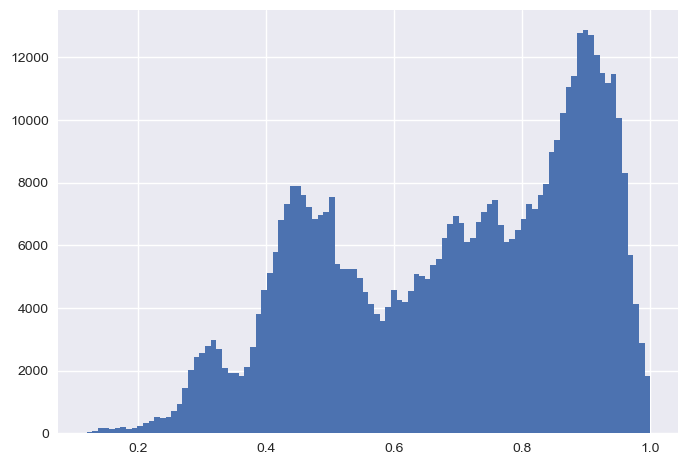

In [3]:
# create similarity matrix for the dataset
dff = pd.read_csv("data/all_votes_main_EP10.csv", low_memory=False)
# only keep the votes with more than 50% participation in the votes
dff = dff[dff.isna().sum(axis=1) < 0.5 * len(dff.columns)]
sim_matrixx = similarity_matrix(dff)
plt.hist(sim_matrixx.flatten(), bins=100)
plt.show()


In [5]:
# ============================================================================
# LOAD DATA AND MAP POLICY AREAS
# ============================================================================

# # Load vote metadata with subjects
# vote_subjects = pd.read_csv("data/votes_with_macrotopics.csv")

# # Extract policy areas from subjects (semicolon-separated)
# policy_area_map = defaultdict(list)
# for _, row in vote_subjects.iterrows():
#     vote_id = str(row['vote_number'])
#     subjects = str(row.get('macrotopic', ''))
    
#     if subjects and subjects != 'nan':
#         areas = [s.strip() for s in subjects.split(';')]
#         for area in areas:
#             if area:
#                 policy_area_map[area].append(vote_id)

# print(f"Found {len(policy_area_map)} unique policy areas")
# print(f"\nTop 20 policy areas by number of votes:")
# for area, votes in sorted(policy_area_map.items(), key=lambda x: len(x[1]), reverse=True)[:20]:
#     print(f"  {area}: {len(votes)} votes")

# Load vote metadata with subjects
EP_number = 10
vote_subjects = pd.read_csv(f"data/votewatch_csv/EP{EP_number}_Voted main docs.csv")

# Extract policy areas from subjects (semicolon-separated)
policy_area_map = defaultdict(list)
for _, row in vote_subjects.iterrows():
    vote_id = str(row['id'])
    subjects = str(row.get('policy_area', ''))
    
    if subjects and subjects != 'nan':
        areas = [s.strip() for s in subjects.split(';')]
        for area in areas:
            if area:
                policy_area_map[area].append(vote_id)

print(f"Found {len(policy_area_map)} unique policy areas")
print(f"\nTop 20 policy areas by number of votes:")
for area, votes in sorted(policy_area_map.items(), key=lambda x: len(x[1]), reverse=True)[:20]:
    print(f"  {area}: {len(votes)} votes")


Found 22 unique policy areas

Top 20 policy areas by number of votes:
  Foreign Affairs: 75 votes
  Environment, Climate and Food Safety: 34 votes
  Budgetary Control: 28 votes
  Budgets: 21 votes
  International Trade: 19 votes
  Economic and Monetary Affairs: 18 votes
  Industry, Research And Energy: 15 votes
  Constitutional Affairs: 14 votes
  Civil Liberties, Justice And Home Affairs: 13 votes
  Agriculture and Rural Development: 10 votes
  Employment And Social Affairs: 9 votes
  Fisheries: 7 votes
  Internal Market And Consumer Protection: 7 votes
  Regional Development: 6 votes
  Women's Rights And Gender Equality: 3 votes
  Transport And Tourism: 3 votes
  European Parliament Delegation To The Budgetary Conciliation Committee: 2 votes
  Petitions: 2 votes
  Legal Affairs: 2 votes
  Political Group: 1 votes


In [7]:
# ============================================================================
# ANALYZE MODULARITY BY POLICY AREA
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain
import networkx as nx
from tqdm import tqdm
import seaborn as sns
import pandas as pd



def mean_num_communities_vs_gamma(G, gammas=None, R=10, seed=42, label="Agriculture"):
    """
    Computes mean number of communities (q) detected by Louvain for different γ.
    """
    if gammas is None:
        gammas = np.arange(0.9, 1.101, 0.01)
        
    results = []
    for gamma in gammas:
        q_list = []
        for r in range(R):
            print(f"Running {r} of {R} for gamma={gamma}")
            part = community_louvain.best_partition(
                G, resolution=gamma, weight='weight', random_state=seed + r
            )
            q_list.append(len(set(part.values())))
        q_mean = np.mean(q_list)
        results.append((gamma, q_mean))
        print(f"γ={gamma:.3f} → mean q={q_mean:.2f}")
    
    # ---- Plot ----
    gammas, q_means = zip(*results)
    plt.figure(figsize=(8, 5))
    plt.plot(gammas, q_means, 'o--', color='crimson', lw=1.5)
    plt.xlabel("Resolution parameter (γ)", fontsize=12)
    plt.ylabel("Mean number of communities (q)", fontsize=12)
    plt.title(f"Mean number q of communities for RCVs related to {label}, R = {R}",
              fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    #plt.savefig(f"figs/q_vs_gamma_{label.replace(' ', '_')}.png", dpi=300)
    plt.show()
    #print(f"✅ Saved q_vs_gamma_{label.replace(' ', '_')}.png")



def plot_party_fraction_per_community(G, df_policy, gamma=1.02, label="Gender equality"):
    """
    Plot fraction of each party's MEPs that belong to each community (Fig. 8.18 style).

    Parameters
    ----------
    G : networkx.Graph
        Similarity or adjacency network of MEPs
    df_policy : pd.DataFrame
        Must contain 'member.id' and 'member.group.short_label'
    gamma : float
        Louvain resolution parameter
    label : str
        Policy area name for title and filename
    """

    # --- Louvain community detection ---
    partition = community_louvain.best_partition(G, resolution=gamma, weight='weight', random_state=42)
    df_policy = df_policy.copy()
    df_policy["community"] = df_policy["member.id"].astype(str).map(partition)

    # --- Count MEPs per party & community ---
    counts = pd.crosstab(df_policy["member.group.short_label"], df_policy["community"])

    # --- Normalize by total MEPs in each PARTY (row-wise) ---
    fractions = counts.div(counts.sum(axis=1), axis=0).fillna(0)

    # --- Plot ---
    plt.figure(figsize=(9, 6))
    colors = sns.color_palette("tab10", n_colors=len(fractions.index))
    fractions.T.plot(kind="bar", color=colors, width=0.8)

    plt.xlabel("Community")
    plt.ylabel("Fraction of MEPs in community (per party)")
    plt.title(
        f"Fraction of MEPs in each community for RCVs related to {label}, γ = {gamma}",
        fontsize=12,
        fontweight="bold"
    )
    plt.legend(
        title="Party",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        fontsize=8,
        title_fontsize=9,
        frameon=False
    )
    plt.grid(alpha=0.3, axis="y")
    plt.tight_layout()
    #plt.savefig(f"figs/party_fraction_per_community_intra_party_{label.replace(' ', '_')}.png", dpi=300)
    plt.show()

    #print(f"✅ Saved party_fraction_per_community_intra_party_{label.replace(' ', '_')}.png")




# Load main vote data
df_all = pd.read_csv(f"data/all_votes_main_EP{EP_number}.csv", low_memory=False)
vote_cols = [c for c in df_all.columns if c.isdigit()]

# Filter top 10 policy areas by number of votes
min_votes = 0# total votes / 10
policy_areas_filtered = {area: votes for area, votes in policy_area_map.items() 
                        if len(votes) >= min_votes}

print(f"Analyzing {len(policy_areas_filtered)} policy areas (with ≥{min_votes} votes)\n")

# Parameters
R = 5  # Number of runs for Qmax

gamma = 1.0  # Resolution parameter

results = []

for policy_area, vote_ids in sorted(policy_areas_filtered.items(), 
                                   key=lambda x: len(x[1]), reverse=True):
    
    # Filter votes for this policy area
    policy_vote_cols = [c for c in vote_cols if c in vote_ids]
    
    if len(policy_vote_cols) < min_votes:
        continue
    
    print(f"Processing: {policy_area} ({len(policy_vote_cols)} votes)...", end=" ")
    
    # Get votes for this policy area
    votes_policy = df_all[policy_vote_cols].copy()
    
    # Remove MEPs with too many missing votes (>70%)
    valid_rows = votes_policy.isna().sum(axis=1) < 0.7 * len(votes_policy.columns)
    votes_policy = votes_policy.loc[valid_rows]
    df_policy = df_all.loc[valid_rows].copy()
    
    if len(votes_policy) < 10:
        print("SKIP (too few MEPs)")
        continue
    
    # Compute similarity matrix
    A = similarity_matrix(votes_policy)
    
    # Create graph
    meps = df_policy['member.id'].astype(str).tolist()
    G = graph_from_similarity(A, meps)
    
    # Remove isolated nodes
    isolated = list(nx.isolates(G))
    if isolated:
        G.remove_nodes_from(isolated)
        df_policy = df_policy[~df_policy['member.id'].astype(str).isin(isolated)].copy()
    
    if G.number_of_nodes() < 10:
        print("SKIP (too few nodes)")
        continue

    # Compute Qmax (mean over R runs)
    Qmax_mean, Qmax_std = compute_qmax(G, R=R, gamma=gamma)

    # Compute Qparty
    party_partition = {}
    if 'member.group.short_label' in df_policy.columns:
        for idx in df_policy.index:
            member_id = str(df_policy.loc[idx, 'member.id'])
            party = str(df_policy.loc[idx, 'member.group.short_label'])
            party_partition[member_id] = party
    Qparty = compute_partition_modularity(G, party_partition)
    
    # Compute Qcountry
    country_partition = {}
    if 'member.country.code' in df_policy.columns:
        for idx in df_policy.index:
            member_id = str(df_policy.loc[idx, 'member.id'])
            country = str(df_policy.loc[idx, 'member.country.code'])
            country_partition[member_id] = country
    Qcountry = compute_partition_modularity(G, country_partition)
    
    # Compute Left-Right modularity
    lr_partition = create_left_right_partition(df_policy)
    Q_left_right = compute_partition_modularity(G, lr_partition)
    
    # Compute Extreme-Centrist modularity
    ec_partition = create_extreme_centrist_partition(df_policy)
    Q_extreme_centrist = compute_partition_modularity(G, ec_partition)

    #mean_num_communities_vs_gamma(G, gammas=np.arange(0.9, 1.1, 0.02), R=10, label=policy_area)
    # plot_party_fraction_per_community(G, df_policy, gamma=1.00, label=policy_area)
    
    
    # Store results
    results.append({
        'Policy Area': policy_area,
        'Qmax': Qmax_mean,
        'Qmax_std': Qmax_std,
        'Qparty': Qparty,
        'Qcountry': Qcountry,
        'Q_left_right': Q_left_right,
        'Q_extreme_centrist': Q_extreme_centrist,
        'Qparty/Qmax': Qparty / Qmax_mean if Qmax_mean > 0 else np.nan,
        'Qcountry/Qmax': Qcountry / Qmax_mean if Qmax_mean > 0 else np.nan,
        'N_votes': len(policy_vote_cols),
        'N_MEPs': G.number_of_nodes()
    })
    
    print(f"Qmax={Qmax_mean:.4f}, Qparty={Qparty:.4f}, Qcountry={Qcountry:.4f}, Q_left_right={Q_left_right:.4f}, Q_extreme_centrist={Q_extreme_centrist:.4f}")

# Create results DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Qmax', ascending=False)

print(f"\n✅ Analysis complete for {len(df_results)} policy areas")


Analyzing 22 policy areas (with ≥0 votes)

Processing: Foreign Affairs (75 votes)... Run 0
Run 1
Run 2
Run 3
Run 4
Qmax=0.0554, Qparty=0.0238, Qcountry=0.0012, Q_left_right=0.0212, Q_extreme_centrist=0.0412
Processing: Environment, Climate and Food Safety (34 votes)... Run 0
Run 1
Run 2
Run 3
Run 4
Qmax=0.1059, Qparty=0.0444, Qcountry=0.0035, Q_left_right=0.0463, Q_extreme_centrist=0.0334
Processing: Budgetary Control (28 votes)... Run 0
Run 1
Run 2
Run 3
Run 4
Qmax=0.0789, Qparty=0.0291, Qcountry=0.0013, Q_left_right=0.0204, Q_extreme_centrist=0.0338
Processing: Budgets (21 votes)... Run 0
Run 1
Run 2
Run 3
Run 4
Qmax=0.0586, Qparty=0.0174, Qcountry=0.0008, Q_left_right=0.0052, Q_extreme_centrist=0.0363
Processing: International Trade (19 votes)... Run 0
Run 1
Run 2
Run 3
Run 4
Qmax=0.0359, Qparty=0.0161, Qcountry=0.0010, Q_left_right=0.0187, Q_extreme_centrist=0.0253
Processing: Economic and Monetary Affairs (18 votes)... Run 0
Run 1
Run 2
Run 3
Run 4
Qmax=0.0664, Qparty=0.0253, Qcou

In [8]:
# ============================================================================
# DISPLAY RESULTS TABLE
# ============================================================================

print("="*80)
print("MODULARITY BY POLICY AREA (γ = 1.0, R = 100 runs)")
print("="*80)

# Display main results
display_cols = ['Policy Area', 'Qmax', 'Qparty', 'Qcountry', 'Q_left_right', 'Q_extreme_centrist', 'Qparty/Qmax', 'Qcountry/Qmax', 'N_votes']
df_display = df_results[display_cols].copy()
df_display['Qmax'] = df_display['Qmax'].round(4)
df_display['Qparty'] = df_display['Qparty'].round(4)
df_display['Qcountry'] = df_display['Qcountry'].round(4)
df_display['Q_left_right'] = df_display['Q_left_right'].round(4)
df_display['Q_extreme_centrist'] = df_display['Q_extreme_centrist'].round(4)
df_display['Qparty/Qmax'] = df_display['Qparty/Qmax'].round(3)
df_display['Qcountry/Qmax'] = df_display['Qcountry/Qmax'].round(3)

print("\n" + df_display.to_string(index=False))

# Save to CSV
#df_results.to_csv('modularity_by_policy_area.csv', index=False)
#print("\n\n✅ Results saved to 'modularity_by_policy_area.csv'")


MODULARITY BY POLICY AREA (γ = 1.0, R = 100 runs)

                                                           Policy Area   Qmax  Qparty  Qcountry  Q_left_right  Q_extreme_centrist  Qparty/Qmax  Qcountry/Qmax  N_votes
                                                       Political Group 0.4048  0.0541    0.0067       -0.0008              0.1430        0.134          0.016        1
                                                           Development 0.3087  0.0553    0.0022        0.0764              0.0160        0.179          0.007        1
European Parliament Delegation To The Budgetary Conciliation Committee 0.2199  0.0810    0.0063        0.0388              0.1000        0.369          0.028        2
                                         Employment And Social Affairs 0.1370  0.0439    0.0020        0.0449              0.0405        0.321          0.015        9
                                                 Culture And Education 0.1348  0.0238    0.0015        0.0057     

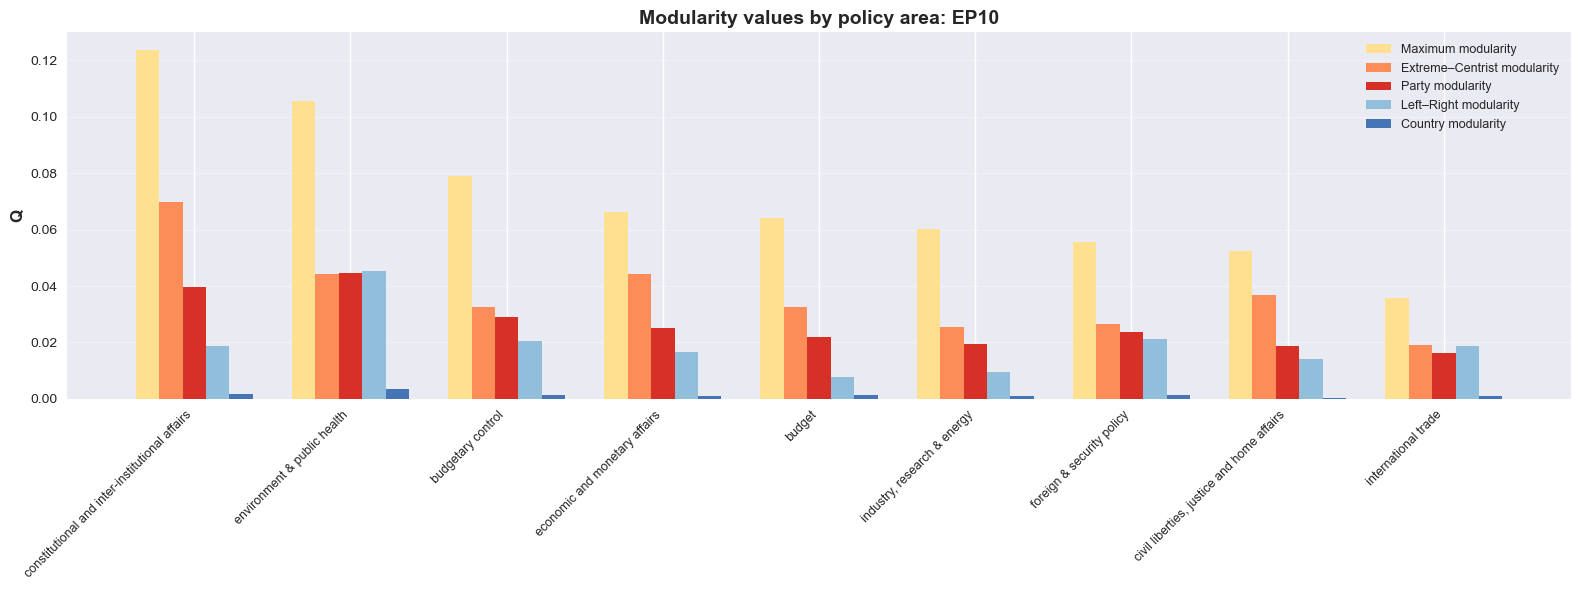

✅ Grouped modularity figure saved as 'modularity_by_policy_area_all.png'


In [256]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Sort or select policy areas if needed ---
df_plot = df_results.copy()
df_plot = df_plot.sort_values("Qmax", ascending=False)

# --- Prepare grouped bar positions ---
x = np.arange(len(df_plot))  # one position per policy area
width = 0.15  # narrower bars to fit 5 groups

fig, ax = plt.subplots(figsize=(16, 6))

# --- Plot the five modularity measures per policy area ---
ax.bar(x - 2*width, df_plot["Qmax"], width, color="#fee090", label="Maximum modularity")
ax.bar(x - width,   df_plot["Q_extreme_centrist"], width, color="#fc8d59", label="Extreme–Centrist modularity")
ax.bar(x,           df_plot["Qparty"], width, color="#d73027", label="Party modularity")
ax.bar(x + width,   df_plot["Q_left_right"], width, color="#91bfdb", label="Left–Right modularity")
ax.bar(x + 2*width, df_plot["Qcountry"], width, color="#4575b4", label="Country modularity")

# --- Axes and labels ---
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Policy Area"], rotation=45, ha="right", fontsize=9)
ax.set_ylabel("Q", fontsize=12, fontweight="bold")
ax.set_title("Modularity values by policy area: EP10", fontsize=14, fontweight="bold")

# --- Legend and style ---
ax.legend(frameon=False, loc="upper right", fontsize=9)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
#plt.savefig("figs/modularity_by_policy_area_all.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Grouped modularity figure saved as 'modularity_by_policy_area_all.png'")

In [22]:
# print ten vote titles per policy area
import random

# Assuming you have the votes dataframe and mapping, let's say df_votes with 'Policy Area' and 'title' columns
# If you don't have it, load it first
df_votes = pd.read_csv("data/votes_with_macrotopics.csv")

# For each policy area, sample and print 10 random vote titles
for policy_area in df_plot["Policy Area"]:
    # Select vote titles within this policy area (ignore case and missing)
    mask = df_votes['macrotopic'].fillna('').str.contains(policy_area, case=False)
    titles = df_votes.loc[mask, 'vote_name'].dropna().unique()

    # Randomly sample up to 10 titles
    sample_titles = random.sample(list(titles), min(10, len(titles)))

    print(f"\nPolicy Area: {policy_area}")
    print("-" * (12 + len(policy_area)))
    for i, t in enumerate(sample_titles, 1):
        print(f"{i}. {t}")




Policy Area: Technology, Digital & Innovation
--------------------------------------------
1. Objection pursuant to Rule 115(2) and (3): genetically modified soybean MON 87705 × MON 87708 × MON 87708 × MON 89788
2. Measures for a high level of public sector interoperability across the Union (Interoperable Europe Act)
3. Cyber Solidarity Act
4. VAT: rules for the digital age
5. Digital Finance: emerging risks in crypto-assets - regulatory and supervisory challenges in the area of financial services, institutions and markets
6. The draft Commission implementing decision renewing the authorisation for the placing on the market of products containing, consisting of or produced from genetically modified maize MON 88017 (MON-88Ø17-3) pursuant to Regulation (EC) No 1829/2003 of the European Parliament and of the Council
7. The draft Commission implementing decision renewing the authorisation for the placing on the market of products containing, consisting of or produced from genetically modi

In [251]:
import pandas as pd
import numpy as np

# Load files
df_voted = pd.read_csv("data/votewatch_csv/EP6_Voted main docs.csv", low_memory=False)
df_7 = pd.read_csv("data/votewatch_csv/EP7_Voted main docs.csv", low_memory=False)
df_8 = pd.read_csv("data/votewatch_csv/EP8_Voted main docs.csv", low_memory=False)
df_9 = pd.read_csv("data/votewatch_csv/EP9_Voted main docs.csv", low_memory=False)
df_10 = pd.read_csv("data/votewatch_csv/EP10_Voted main docs.csv", low_memory=False)

# Define a cleaning function
def clean_policy(series):
    return (
        series.astype(str)
        .str.strip()                # remove leading/trailing spaces
        .str.replace(r'\s+', ' ', regex=True)  # collapse multiple spaces
        .str.lower()                # harmonize case
    )

# Apply cleaning
df_voted['main_policy_name'] = clean_policy(df_voted['main_policy_name'])
df_7['De'] = clean_policy(df_7['De'])
df_8['De'] = clean_policy(df_8['De'])
df_9['committees'] = clean_policy(df_9['committees'])
df_10['committees'] = clean_policy(df_10['committees'])
# drop nan
df_8 = df_8.dropna(subset=['De'])

# Get unique, sorted values
main_policy_area_6 = np.sort(df_voted['main_policy_name'].unique())
main_policy_area_7 = np.sort(df_7['De'].unique())
main_policy_area_8 = np.sort(df_8['De'].unique())
main_policy_area_9 = np.sort(df_9['committees'].unique())
main_policy_area_10 = np.sort(df_10['committees'].unique())
# Print to check
print(main_policy_area_6)
# print(main_policy_area_7)
# print(main_policy_area_8)
print(main_policy_area_9)
print(main_policy_area_10)

# df_voted.to_csv("data/votewatch_csv/EP6_Voted main docs.csv", index=False)
# df_7.to_csv("data/votewatch_csv/EP7_Voted main docs.csv", index=False)
# df_8.to_csv("data/votewatch_csv/EP8_Voted main docs.csv", index=False)
#df_9.to_csv("data/votewatch_csv/EP9_Voted docs old.csv", index=False)
# print toal number of policy areas per dataset
print(len(main_policy_area_6))
print(len(main_policy_area_7))
print(len(main_policy_area_8))
print(len(main_policy_area_9))
print(len(main_policy_area_10))

# print toal number of policy areas per dataset

['agriculture' 'budget' 'budgetary control'
 'civil liberties, justice & home affairs'
 'constitutional and inter-institutional affairs' 'culture & education'
 'development' 'economics' 'employment & social affairs'
 'environment & public health' 'fisheries' 'foreign & security policy'
 'gender equality' 'industry, research & energy'
 'internal market & consumer protection' 'internal regulations of the ep'
 'international trade' 'juridical affairs' 'petitions'
 'regional development' 'transport & tourism']
['agriculture' 'budget' 'budgetary control'
 'civil liberties, justice & home affairs'
 'constitutional and inter-institutional affairs' 'culture & education'
 'development' 'economic & monetary affairs' 'employment & social affairs'
 'environment & public health' 'fisheries' 'foreign & security policy'
 'gender equality' 'industry, research & energy'
 'internal market & consumer protection' 'internal regulations of the ep'
 'international trade' 'legal affairs' 'nan' 'petitions'
 'r

In [250]:
# in dataset 10, all lines where committees is 'agriculture and rural development' are changed to 'agriculture'
df_9['committees'] = df_9['committees'].replace('employment and social affairs', 'employment & social affairs')
# write to csv
df_9.to_csv("data/votewatch_csv/EP9_Voted main docs.csv", index=False)


In [98]:
df_10 = pd.read_csv("new.csv")
# sort committees unique
df_10 = df_10.explode('committees')
# sort them alphabetically
# remove nans
df_10 = df_10[df_10['committees'].notna()]
# sort them alphabetically
sorted_committees = np.sort(df_10['committees'].unique())
print(sorted_committees)

# print the number of unique committees
print(len(sorted_committees))


['Agriculture and Rural Development' 'Budgetary Control' 'Budgets'
 'Civil Liberties, Justice and Home Affairs' 'Constitutional Affairs'
 'Culture and Education' 'Development' 'Economic and Monetary Affairs'
 'Employment and Social Affairs' 'Environment, Climate and Food Safety'
 'European Parliament delegation to the Budgetary Conciliation Committee'
 'Fisheries' 'Foreign Affairs' 'Industry, Research and Energy'
 'Internal Market and Consumer Protection' 'International Trade'
 'Legal Affairs' 'Petitions' 'Regional Development'
 'Special Committee on Artificial Intelligence in a Digital Age'
 'Special Committee on Beating Cancer'
 'Special Committee on Foreign Interference in all Democratic Processes in the European Union, including Disinformation'
 'Transport and Tourism' 'Women’s Rights and Gender Equality']
24


In [131]:
# for ep9 and ep10 print the number of nan in the committees column
df_9 = pd.read_csv("data/EP9_Voted_main_docs_with_committees.csv")
print(df_9['committees'].isna().sum())
# df_10 = pd.read_csv("data/EP10_Voted_main_docs_with_committees.csv")
# print(df_10['committees'].isna().sum())

# get file with only nan committees lines
df_9_nan = df_9[df_9['committees'].isna()]


# save to csv
df_9_nan.to_csv("data/EP9_Voted_main_docs_with_committees_nan.csv", index=False)


404


In [186]:
import pandas as pd

# Load your CSV
df = pd.read_csv("data/EP9_Voted_main_docs_with_committees.csv")

# Define mapping: keywords → committee
committee_keywords = {
    'agricultur': 'agriculture',
    'farm': 'agriculture',
    'budget': 'budget',
    'discharge': 'budgetary control',
    'justice': 'civil liberties, justice & home affairs',
    'liberties': 'civil liberties, justice & home affairs',
    'freedom': 'civil liberties, justice & home affairs',
    'rights': 'civil liberties, justice & home affairs',
    'discrimination': 'civil liberties, justice & home affairs',
    'discrimin': 'civil liberties, justice & home affairs',
    'constitution': 'constitutional and inter-institutional affairs',
    'treaty': 'constitutional and inter-institutional affairs',
    'education': 'culture & education',
    'culture': 'culture & education',
    'development': 'development',
    'cooperation': 'development',
    'economic': 'economic & monetary affairs',
    'finance': 'economic & monetary affairs',
    'employment': 'employment & social affairs',
    'social': 'employment & social affairs',
    'environment': 'environment & public health',
    'climate': 'environment & public health',
    'health': 'environment & public health',
    'fisher': 'fisheries',
    'foreign': 'foreign & security policy',
    'security': 'foreign & security policy',
    'defence': 'foreign & security policy',
    'gender': 'gender equality',
    'women': 'gender equality',
    'research': 'industry, research & energy',
    'energy': 'industry, research & energy',
    'industry': 'industry, research & energy',
    'consumer': 'internal market & consumer protection',
    'market': 'internal market & consumer protection',
    'internal regulation': 'internal regulations of the ep',
    'the draft commission': 'internal regulations of the ep',
    'trade': 'international trade',
    'export': 'international trade',
    'legal': 'legal affairs',
    'petition': 'petitions',
    'regional': 'regional development',
    'transport': 'transport & tourism',
    'tourism': 'transport & tourism',
    'russia': 'foreign & security policy',
    'iran': 'foreign & security policy',
    'turkey': 'foreign & security policy',
    'ukraine': 'foreign & security policy',
    'venezuela': 'foreign & security policy',
    'china': 'foreign & security policy',
    'india': 'foreign & security policy',
    'brazil': 'foreign & security policy',
    'argentina': 'foreign & security policy',
    'chile': 'foreign & security policy', 
    'armenia': 'foreign & security policy',
    'azerbaijan': 'foreign & security policy',
    'belarus': 'foreign & security policy',
    'georgia': 'foreign & security policy',
    'kazakhstan': 'foreign & security policy',
    'kyrgyzstan': 'foreign & security policy',
    'cuba': 'foreign & security policy',
    'gaza': 'foreign & security policy',
    'palestine': 'foreign & security policy',
    'israel': 'foreign & security policy',
    'palestinian': 'foreign & security policy',
    'palestinian authority': 'foreign & security policy',
    'palestinian people': 'foreign & security policy',
    'malta': 'foreign & security policy',
    'moldova': 'foreign & security policy',
    'macedonia': 'foreign & security policy',
    'digital': 'industry, research & energy',
    'cyber': 'industry, research & energy',
    'cybersecurity': 'industry, research & energy',
    'situation in': 'foreign & security policy',
    'situation of': 'foreign & security policy',
    'Myanmar': 'foreign & security policy',
    'fishing': 'fisheries',

    "Commission Implementing Regulation (EU) 2019/707": "environment & public health",
    "The European Green Deal": "environment & public health",
    "The Chemicals Strategy for Sustainability": "environment & public health",
    "Emission limits and type-approval for internal": "transport & tourism",
    "Real Driving Emissions": "transport & tourism",
    "Soil protection": "environment & public health",
    "The implementation of the EU water legislation": "environment & public health",
    "Fishing authorisations for Union fishing vesse": "fisheries",
    "Objection pursuant to Rule 112(2) and (3): Act": "environment & public health",
    "Commission Implementing Regulation (EU) 2021/7": "environment & public health",
    "Objection pursuant to Rule 112(2) and (3): Ant": "environment & public health",
    "Commission Implementing Regulation (EU) 2020/1": "environment & public health",
    "Measures against water pollution caused by nit": "environment & public health",
    "Packaging and labelling of veterinary medicina": "agriculture",
    "Union procedures for the authorisation and sup": "environment & public health",
    "Simplification of certain CAP rules": "agriculture",

    # --- Budget, finance, economy ---
    "The state of play on the proposal for a direct": "economic & monetary affairs",
    "The new multiannual financial framework": "budget",
    "The Multiannual Financial Framework 2021-2027": "budget",
    "Reforming the EU list of tax havens": "economic & monetary affairs",
    "Pandora Papers": "economic & monetary affairs",
    "National vetoes to undermine the global tax deal": "economic & monetary affairs",
    "Multiannual financial framework for the years": "budget",
    "Establishment of a diversified funding strateg": "budget",
    "A European strategy for critical raw materials": "industry, research & energy",

    # --- Institutional & rule of law topics ---
    "The European Parliament’s position on the Conf": "constitutional and inter-institutional affairs",
    "Ongoing hearings under Article 7(1) of the TEU": "civil liberties, justice & home affairs",
    "The Rule of law crisis in Poland": "civil liberties, justice & home affairs",
    "Assessment of Hungary's compliance with the ru": "civil liberties, justice & home affairs",
    "The establishment of the EU ethics body": "constitutional and inter-institutional affairs",
    "Recommendations for reform of European Parliam": "constitutional and inter-institutional affairs",
    "The call for a Convention for the revision of": "constitutional and inter-institutional affairs",
    "Frontex, building on the fact-finding investig": "civil liberties, justice & home affairs",
    "Following up on measures requested by Parliame": "constitutional and inter-institutional affairs",

    # --- Foreign affairs & human rights ---
    "The commemoration of the 30th anniversary of t": "foreign & security policy",
    "The case of Dr. Denis Mukwege": "foreign & security policy",
    "Eritrea, notably the case of Dawit Isaak": "foreign & security policy",
    "Rwanda, the case of Paul Rusesabagina": "foreign & security policy",
    "The Syrian conflict – 10 years after the uprising": "foreign & security policy",
    "The mass trials against opposition": "foreign & security policy",
    "Political crisis in Sudan": "foreign & security policy",
    "Political crisis in Burkina Faso": "foreign & security policy",
    "Myanmar, one year after the coup": "foreign & security policy",
    "Myanmar, notably the dissolution of democratic": "foreign & security policy",
    "Hong Kong, notably the case of Apple Daily": "foreign & security policy",
    "The death penalty in Saudi Arabia": "foreign & security policy",
    "Nicaragua, in particular the arrest": "foreign & security policy",
    "Egypt, in particular the sentencing": "foreign & security policy",
    "Tajikistan: state repression": "foreign & security policy",
    "Norway’s recent decision to advance seabed min": "foreign & security policy",
    "The case of Zarema Musaeva": "foreign & security policy",
    "The Maasai Communities in Tanzania": "foreign & security policy",
    "Attempt of coup d’Etat in Guatemala": "foreign & security policy",

    # --- Social policy, gender, culture ---
    "female genital": "gender equality",
    "The European Disability Strategy post2020": "employment & social affairs",
    "The Youth Guarantee": "employment & social affairs",
    "European Child Guarantee": "employment & social affairs",
    "The accessibility and affordability of Covid-t": "employment & social affairs",
    "The anti-racism protests following the death o": "civil liberties, justice & home affairs",
    "MeToo and harassment": "gender equality",
    "Growing hate crimes against LGBTIQ+": "civil liberties, justice & home affairs",
    "The cultural recovery of Europe": "culture & education",

    # --- Trade & international development ---
    "The proposed mandate for negotiations for a ne": "international trade",
    "The impact of Covid-19 on youth and on sport": "culture & education",
    "Momentum for the ocean: strengthening ocean go": "fisheries",
    "Implementation of the Kimberley Process": "international trade",
    "Multilateral negotiations in view of the 12th": "international trade",

    # --- Internal market, consumer protection, transport ---
    "A common charger for mobile radio equipment": "internal market & consumer protection",
    "Right to repair": "internal market & consumer protection",
    "Slot utilisation rules at Union airports": "transport & tourism",
    "Temporary relief from the slot utilisation rul": "transport & tourism",
    "The safety of truck parking lots in the EU": "transport & tourism",

    # --- Data protection & digital issues ---
    "The adequate protection of personal data": "civil liberties, justice & home affairs",
    "Data Protection Commissioner v Facebook": "civil liberties, justice & home affairs",
    "The right of information of the Parliament reg": "constitutional and inter-institutional affairs",
    "The risk of the death penalty and the executio": "foreign & security policy",
    "The establishment of an independent EU ethics": "constitutional and inter-institutional affairs",

    "qatar": "foreign & security policy",
    "holodomor": "foreign & security policy",
    "american": "foreign & security policy",
    "naval": "foreign & security policy",
    
}

# --- NEWLY ADDED KEYWORDS TO IMPROVE COVERAGE ---

extra_keywords = {
    # --- Justice, rule of law, democracy ---
    "rule of law": "civil liberties, justice & home affairs",
    "european court of justice": "civil liberties, justice & home affairs",
    "conflict of interest": "civil liberties, justice & home affairs",
    "anti-corruption": "civil liberties, justice & home affairs",
    "electoral law": "constitutional and inter-institutional affairs",
    "minority": "civil liberties, justice & home affairs",
    "citizens' initiative": "constitutional and inter-institutional affairs",
    "refugees": "civil liberties, justice & home affairs",
    "migration": "civil liberties, justice & home affairs",
    "abortion": "civil liberties, justice & home affairs",
    "eurojust": "civil liberties, justice & home affairs",

    # --- Health & environment ---
    "clinical trials": "environment & public health",
    "medical devices": "environment & public health",
    "antimicrobial resistance": "environment & public health",
    "covid": "environment & public health",
    "pandemic": "environment & public health",
    "public health": "environment & public health",
    "soil": "environment & public health",
    "machinery": "environment & public health",

    # --- Agriculture & rural ---
    "organic production": "agriculture",
    "cage age": "agriculture",
    "farm animal": "agriculture",
    "cap": "agriculture",
    "agricultural": "agriculture",

    # --- Industry & internal market ---
    "industrial": "industry, research & energy",
    "machinery": "industry, research & energy",
    "react-eu": "budget",
    "ammunition production": "industry, research & energy",
    "critical raw materials": "industry, research & energy",
    "energy": "industry, research & energy",

    # --- Transport & infrastructure ---
    "railway": "transport & tourism",
    "infrastructure": "transport & tourism",
    "safety certificates": "transport & tourism",

    # --- Budget & finance ---
    "value added tax": "economic & monetary affairs",
    "vat": "economic & monetary affairs",
    "financing": "budget",
    "financial framework": "budget",
    "pre-financing": "budget",
    "budgetary": "budget",
    "reopening of the investigation": "budgetary control",
    "evaluation report": "budgetary control",
    "lack of legislative follow-up": "constitutional and inter-institutional affairs",

    # --- International & foreign affairs ---
    "blasphemy laws": "foreign & security policy",
    "pakistan": "foreign & security policy",
    "colombia": "foreign & security policy",
    "nagorno-karabakh": "foreign & security policy",
    "china": "foreign & security policy",
    "rwanda": "foreign & security policy",
    "bolivia": "foreign & security policy",
    "equatorial": "foreign & security policy",
    "tibet": "foreign & security policy",
    "sudan": "foreign & security policy",
    "burkina faso": "foreign & security policy",
    "schengen": "foreign & security policy",
    "romania": "foreign & security policy",
    "bulgaria": "foreign & security policy",
    "antarctic": "foreign & security policy",
    "ammunition": "foreign & security policy",
    "war": "foreign & security policy",
    "humanitarian": "foreign & security policy",
    "defence": "foreign & security policy",
    "foreign": "foreign & security policy",
    "ukraine": "foreign & security policy",

    # --- Culture, education, communication ---
    "euranet": "culture & education",
    "greener cities": "environment & public health",
    "sport": "culture & education",
    "education": "culture & education",

    # --- Institutional affairs ---
    "eu-uk negotiations": "constitutional and inter-institutional affairs",
    "commission evaluation": "constitutional and inter-institutional affairs",
    "delegation": "constitutional and inter-institutional affairs",
    "special committee": "constitutional and inter-institutional affairs",
    "numerical strength": "constitutional and inter-institutional affairs",
    "copenhagen criteria": "constitutional and inter-institutional affairs",
    "commission takes to deal": "constitutional and inter-institutional affairs",
    "regulation": "internal regulations of the ep",
}

# Merge with your existing dictionary
committee_keywords.update(extra_keywords)

import pandas as pd

# Load your CSV
df = pd.read_csv("data/EP9_Voted_main_docs_with_inferred_committees.csv")

# ✅ Replace the dots below with your actual big dictionary

# --- lowercase all dictionary keys ---
committee_keywords = {k.lower(): v for k, v in committee_keywords.items()}

def guess_committee(row):
    text = " ".join(str(row[col]).lower() for col in ['display_title', 'procedure_title', 'description'])
    for keyword, committee in committee_keywords.items():
        if keyword in text:
            return committee
    return None

# Apply guessing only where committees are missing
df['committees'] = df['committees'].fillna(df.apply(guess_committee, axis=1))

# Save result
df.to_csv("data/EP9_Voted_main_docs_with_inferred_committees.csv", index=False)

print("✅ Committees inferred and file saved as 'data/EP9_Voted_main_docs_with_inferred_committees.csv'")
print(df['committees'].value_counts(dropna=False))
print("Still missing:", df['committees'].isna().sum())

✅ Committees inferred and file saved as 'data/EP9_Voted_main_docs_with_inferred_committees.csv'
committees
Budgetary Control                                                                                                        334
foreign & security policy                                                                                                151
Environment, Climate and Food Safety                                                                                     129
Foreign Affairs                                                                                                          112
Economic and Monetary Affairs                                                                                            107
Civil Liberties, Justice and Home Affairs                                                                                 97
civil liberties, justice & home affairs                                                                                   76
Budgets           

In [187]:
# print none committees
df = pd.read_csv("data/EP9_Voted_main_docs_with_inferred_committees.csv")
pd.set_option('display.max_rows', None)
# only print the title of the none committees, display all output
df[df['committees'].isna()]['display_title']


1228    NaN
Name: display_title, dtype: object

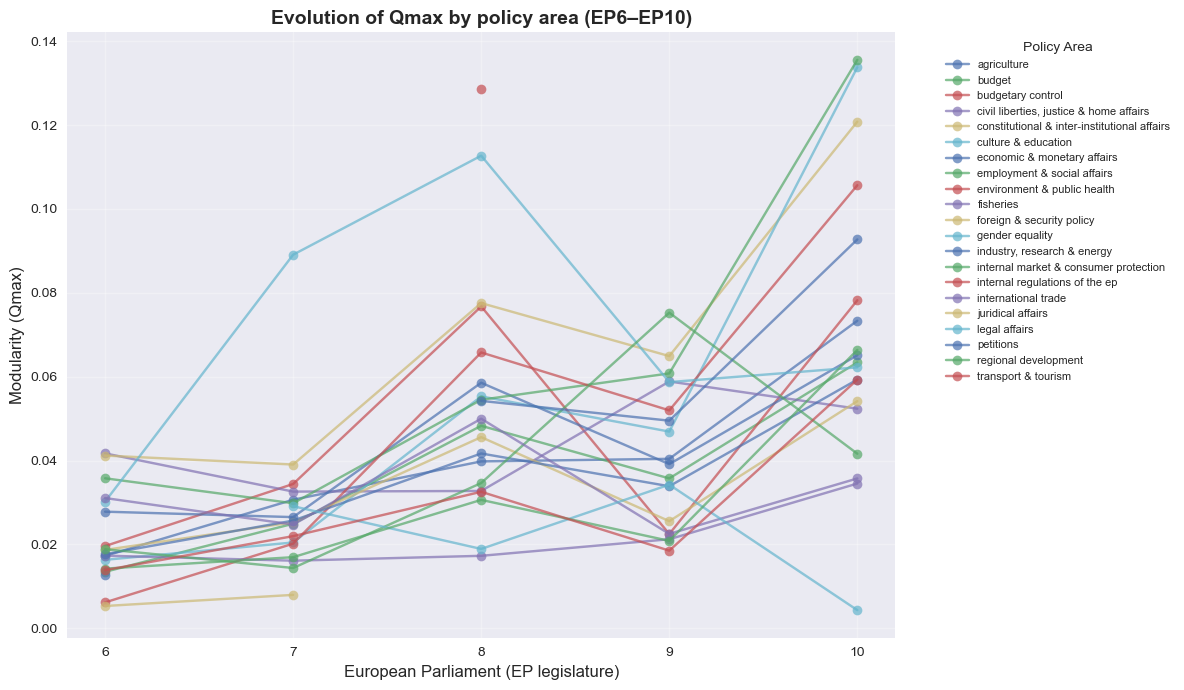

✅ Plot saved as figs/evolution_Qmax_by_policy_area.png


In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Parameters ---
EP_LIST = [6, 7, 8, 9, 10]
metric = "Qmax"   # choose: Qparty, Qcountry, Q_left_right, Q_extreme_centrist, Q_random, Qmax
folder = "results"

# --- Load all EP results ---
dfs = []
for ep in EP_LIST:
    file_path = os.path.join(folder, f"modularity_results_EP{ep}.csv")
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        continue
    df = pd.read_csv(file_path)
    df["EP"] = ep
    dfs.append(df)

if not dfs:
    raise FileNotFoundError("❌ No modularity result files found.")

df_all = pd.concat(dfs, ignore_index=True)

# --- Keep only relevant columns ---
df_all = df_all[["EP", "Policy Area", metric]].dropna()

# --- Pivot: Policy Area x EP ---
pivot = df_all.pivot_table(index="EP", columns="Policy Area", values=metric)

# dont plot development
pivot = pivot.drop(columns=['development'])

# --- Plot ---
plt.figure(figsize=(12, 7))

for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", alpha=0.7, label=col)

plt.xlabel("European Parliament (EP legislature)", fontsize=12)
plt.ylabel(f"Modularity ({metric})", fontsize=12)
plt.title(f"Evolution of {metric} by policy area (EP6–EP10)", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3)
plt.xticks(EP_LIST)
plt.legend(title="Policy Area", fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(f"figs/evolution_{metric}_by_policy_area.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Plot saved as figs/evolution_{metric}_by_policy_area.png")

In [130]:
import pandas as pd

# Paths
old_path = "data/EP9_Voted_main_docs_with_committees.csv"   # file with all votes (some empty committees)
new_path = "data/EP9_Voted_main_docs_with_committees_nan.csv"                                      # file with manually added committees
out_path = "data/aaaaaaaaaa.csv"

# Load both
df_old = pd.read_csv(old_path)
df_new = pd.read_csv(new_path)

# --- Normalize IDs (make sure they are strings and stripped) ---
df_old["id"] = df_old["id"].astype(str).str.strip()
df_new["id"] = df_new["id"].astype(str).str.strip()

# --- Create a mapping from id → committees (from new file) ---
id_to_committee = df_new.set_index("id")["committees"].to_dict()

# --- Update only missing committees in old file ---
updated = df_old.copy()
mask_missing = updated["committees"].isna() | (updated["committees"].astype(str).str.strip() == "")
updated.loc[mask_missing, "committees"] = updated.loc[mask_missing, "id"].map(id_to_committee).combine_first(
    updated.loc[mask_missing, "committees"]
)

# --- Diagnostics ---
print(f"✅ Before: {df_old['committees'].notna().sum()} non-empty committees")
print(f"✅ After:  {updated['committees'].notna().sum()} non-empty committees")

# --- Save updated file ---
updated.to_csv(out_path, index=False)
print(f"💾 Saved updated file as: {out_path}")

✅ Before: 211 non-empty committees
✅ After:  289 non-empty committees
💾 Saved updated file as: data/aaaaaaaaaa.csv


In [119]:
import pandas as pd

df_9 = pd.read_csv("data/votewatch_csv/EP9_Voted docs old.csv")
print(df_9.columns)
# Filter rows where 'Committee responsabile' == 0 and 'Final vote?' == 1.0
df_filtered = df_9[(df_9['Committee responsabile'] == '0') & (df_9['Final vote?'] == 1.0)]
print(df_filtered.columns)
# Show only relevant columns
print(df_filtered[['Title', 'De', 'Final vote?']])
df_filtered = df_filtered[['Title', 'De']]
# save df_filtered to csv
df_filtered.to_csv("aaaa.csv", index=False)

Index(['Vote ID', 'File', 'Order of vote', 'Date', 'Title', 'Procedure',
       'Leg/Non-Leg/Bud', 'Type of Vote', 'Voting Rule', 'Rapporteur', 'Code',
       'Interinstitutional file number', 'Link', 'Committee responsabile',
       'De', 'Subject', 'Final vote?', 'Am No.', 'Author', 'RCV', 'Vote',
       'Yes', 'No', 'Abs'],
      dtype='object')
Index(['Vote ID', 'File', 'Order of vote', 'Date', 'Title', 'Procedure',
       'Leg/Non-Leg/Bud', 'Type of Vote', 'Voting Rule', 'Rapporteur', 'Code',
       'Interinstitutional file number', 'Link', 'Committee responsabile',
       'De', 'Subject', 'Final vote?', 'Am No.', 'Author', 'RCV', 'Vote',
       'Yes', 'No', 'Abs'],
      dtype='object')
                                                   Title   
0                 Tuesday - request by the GUE/NGL group  \
9                                 Situation in Venezuela   
10     Changes to the agenda - request by Greens/EFA ...   
11     Changes to the agenda - request by ID and GUE/NGL  

In [67]:
missing = df_8[df_8['De'].isna()]
print(missing)

      Vote ID  File  Order of vote        Date  O'clock   
1340     6573   NaN            1.0  28.02.2018      NaN  \

                                                  Title Title_Ro Title_Fr   
1340  Changes to the agenda (28 February 2018) -  re...      NaN      NaN  \

     Title_German Title_Polski  ... Subject_pl Final vote? Am No. Author  RCV   
1340          NaN          NaN  ...        NaN         1.0    NaN      0  RCV  \

     Vote Yeas   No Abs is_main  
1340    +  241  133   8     1.0  

[1 rows x 34 columns]


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain


def graph_from_similarity(A, meps, min_weight=0.0):
    """Convert similarity matrix A ∈ [0,1] into weighted graph.
    
    Args:
        A: adjacency matrix (n x n)
        meps: list of MEP identifiers (length n)
        min_weight: minimum edge weight to include (default: 0.0, include all)
    """
    G = nx.Graph()
    # Add all nodes first
    for m in meps:
        G.add_node(m)
    
    # Add edges with weights above threshold
    for i in range(len(meps)):
        for j in range(i + 1, len(meps)):
            w = A[i, j]
            if not np.isnan(w) and w >= min_weight:
                G.add_edge(meps[i], meps[j], weight=w)
    
    return G


def compute_modularity_measures(G, node_metadata, partitions):
    """Compute modularity Q for specified partitions and Louvain Qmax."""
    # Ensure DataFrame index matches graph nodes
    node_metadata = node_metadata.copy()
    
    # Try to match nodes by member.id if available, otherwise by index
    if 'member.id' in node_metadata.columns:
        node_metadata['_node_key'] = node_metadata['member.id'].astype(str)
    else:
        node_metadata['_node_key'] = node_metadata.index.astype(str)
    
    node_metadata = node_metadata.set_index('_node_key')

    results = []
    for name, col in partitions.items():
        if col not in node_metadata.columns:
            print(f"⚠️ Missing column '{col}' in metadata, skipping {name}")
            continue
        
        # Build mapping node -> community (only for nodes present in both graph and metadata)
        mapping = {}
        missing_nodes = []
        for n in G.nodes():
            n_str = str(n)
            if n_str in node_metadata.index:
                mapping[n] = str(node_metadata.loc[n_str, col])
            else:
                missing_nodes.append(n)
        
        if missing_nodes:
            print(f"⚠️ Warning: {len(missing_nodes)} graph nodes not found in metadata for {name}")
        
        if len(mapping) == 0:
            print(f"⚠️ No matching nodes found for {name}, skipping")
            continue
            
        # Filter graph to only nodes in mapping (if needed)
        if len(mapping) < G.number_of_nodes():
            G_filtered = G.subgraph(mapping.keys()).copy()
        else:
            G_filtered = G
        
        if G_filtered.number_of_nodes() == 0:
            print(f"⚠️ Empty graph after filtering for {name}, skipping")
            continue
            
        try:
            Q = community_louvain.modularity(mapping, G_filtered, weight='weight')
            results.append((name, Q))
            print(f"{name:15s} modularity Q = {Q:.3f} (nodes: {G_filtered.number_of_nodes()})")
        except Exception as e:
            print(f"⚠️ Error computing modularity for {name}: {e}")
            continue

    # Louvain best partition (Qmax) - use full graph
    try:
        best_partition = community_louvain.best_partition(G, weight='weight')
        Qmax = community_louvain.modularity(best_partition, G, weight='weight')
        results.append(("Louvain (Qmax)", Qmax))
        print(f"{'Louvain (Qmax)':15s} modularity Q = {Qmax:.3f} (nodes: {G.number_of_nodes()})")
    except Exception as e:
        print(f"⚠️ Error computing Louvain modularity: {e}")

    return pd.DataFrame(results, columns=["Partition", "Q_value"])



def similarity_matrix(vote_df):
    vote_cols = [c for c in vote_df.columns if c.isdigit()]

    # Map votes
    mapping = {
        'FOR': 1,
        'AGAINST': -1,
        'ABSTENTION': 0,
        'DID_NOT_VOTE': np.nan
    }
    V = vote_df[vote_cols].replace(mapping).to_numpy(dtype=float)
    n = V.shape[0]

    # Masks for each vote type
    yes = (V == 1).astype(float)
    no = (V == -1).astype(float)
    abst = (V == 0).astype(float)
    valid = ~np.isnan(V)

    # Initialize score and count matrices
    S = np.zeros((n, n))
    counts = np.zeros((n, n))

    # Only compare over resolutions where both voted (exclude DID_NOT_VOTE)
    both_voted = (valid @ valid.T)

    # Rule-based contributions
    # +1 for yes–yes and no–no
    S += yes @ yes.T + no @ no.T
    counts += yes @ yes.T + no @ no.T

    # -1 for yes–no or no–yes
    neg_pairs = yes @ no.T + no @ yes.T
    S -= neg_pairs
    counts += neg_pairs

    # -0.25 for yes–abstain or no–abstain
    mixed = (yes @ abst.T) + (abst @ yes.T) + (no @ abst.T) + (abst @ no.T)
    S += -0.25 * mixed
    counts += mixed

    # +0.25 for abstain–abstain
    abst_pairs = abst @ abst.T
    S += 0.25 * abst_pairs
    counts += abst_pairs

    # Normalize only over resolutions where both MEPs cast a vote (exclude NaNs)
    S = np.divide(S, counts, out=np.zeros_like(S), where=counts > 0)

    # Convert to A_ij = 0.5 * S_ij + 0.5
    A = 0.5 * S + 0.5

    # pairs that never voted together → neutral 0.5
    A[np.isnan(A)] = 0.5

    # diagonal = 1
    np.fill_diagonal(A, 1.0)

    print(f"✅ Similarity S range = [{np.nanmin(S):.3f}, {np.nanmax(S):.3f}]")
    print(f"✅ Adjacency A range = [{np.nanmin(A):.3f}, {np.nanmax(A):.3f}]")
    print(f"Matrix shape: {A.shape}")
    print(f"Neutral pairs (no shared votes): {(counts == 0).sum()}")

    return A

df = pd.read_csv("data/all_votes_main_EP10.csv", low_memory=False)
sim_matrix = similarity_matrix(df)


✅ Similarity S range = [-1.000, 1.000]
✅ Adjacency A range = [0.000, 1.000]
Matrix shape: (744, 744)
Neutral pairs (no shared votes): 8321


In [20]:
# check which ones are negative
negative_indices = np.where(sim_matrix < 0)
print(negative_indices)

# check nan
nan_indices = np.where(np.isnan(sim_matrix))
print(nan_indices)

# assert no negative
assert np.all(sim_matrix >= 0)

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


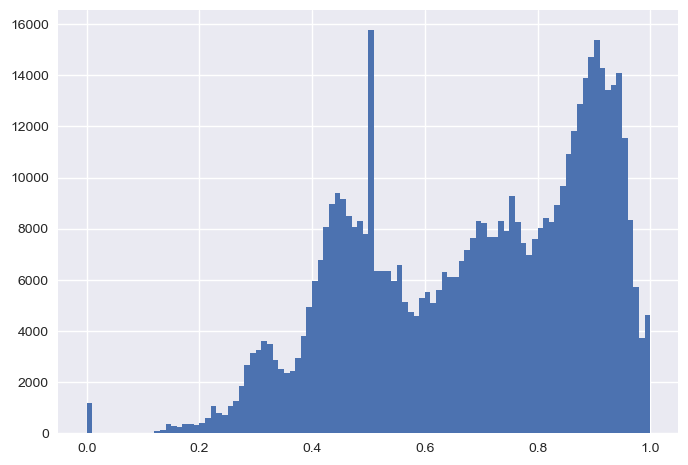

In [21]:
# plot distribution of similarity matrix but exclude the diagonal
plt.hist(sim_matrix.flatten(), bins=100)
plt.show()

In [22]:
meps = df['member.id'].astype(str).tolist()

# Create graph from similarity matrix
# Note: sim_matrix is the adjacency matrix A from Cell 0
G = graph_from_similarity(sim_matrix, meps)

# Remove isolated nodes (degree 0) which can cause modularity errors
isolated = list(nx.isolates(G))
if isolated:
    print(f"⚠️ Removing {len(isolated)} isolated nodes")
    G.remove_nodes_from(isolated)
    # Also remove from dataframe for partition matching
    if 'member.id' in df.columns:
        df_filtered = df[~df['member.id'].astype(str).isin(isolated)].copy()
    else:
        df_filtered = df[~df.index.astype(str).isin(isolated)].copy()
else:
    df_filtered = df.copy()

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Choose which partitions to test
partitions_to_test = {
    "Party": "member.group.short_label",
    "Country": "member.country.code"
}

# Compute modularity
df_mod = compute_modularity_measures(G, df_filtered, partitions_to_test)
print("\nModularity summary:\n", df_mod)

Graph: 734 nodes, 269021 edges
Party           modularity Q = 0.027 (nodes: 734)
Country         modularity Q = 0.002 (nodes: 734)
Louvain (Qmax)  modularity Q = 0.057 (nodes: 734)

Modularity summary:
         Partition   Q_value
0           Party  0.026629
1         Country  0.001567
2  Louvain (Qmax)  0.057116


In [23]:
# ============================================================================
# MODULARITY ANALYSIS SYSTEM
# ============================================================================

from collections import Counter
from itertools import combinations
import random
from scipy.stats import norm
from scipy.special import comb

def nvi(X, Y):
    """
    Normalized Variation of Information (NVI) between two partitions.
    
    Args:
        X, Y: dict mapping node -> community label
    
    Returns:
        float: NVI value in [0, 1] (0 = identical partitions, 1 = maximum dissimilarity)
    """
    # Get all nodes
    nodes = set(X.keys()) | set(Y.keys())
    if len(nodes) == 0:
        return 0.0
    
    # Count communities
    c_X = Counter(X.values())
    c_Y = Counter(Y.values())
    
    # Joint distribution
    joint = Counter()
    for node in nodes:
        if node in X and node in Y:
            joint[(X[node], Y[node])] += 1
    
    # Normalize
    n = len(nodes)
    p_X = {k: v/n for k, v in c_X.items()}
    p_Y = {k: v/n for k, v in c_Y.items()}
    p_XY = {k: v/n for k, v in joint.items()}
    
    # Entropy H(X)
    H_X = -sum(p * np.log2(p) if p > 0 else 0 for p in p_X.values())
    
    # Entropy H(Y)
    H_Y = -sum(p * np.log2(p) if p > 0 else 0 for p in p_Y.values())
    
    # Joint entropy H(X,Y)
    H_XY = -sum(p * np.log2(p) if p > 0 else 0 for p in p_XY.values())
    
    # Mutual information I(X;Y) = H(X) + H(Y) - H(X,Y)
    I_XY = H_X + H_Y - H_XY
    
    # Variation of Information VI(X,Y) = H(X) + H(Y) - 2*I(X,Y)
    VI = H_X + H_Y - 2 * I_XY
    
    # Normalize by max entropy
    max_H = max(H_X, H_Y) if max(H_X, H_Y) > 0 else 1.0
    NVI = VI / max_H if max_H > 0 else 0.0
    
    return NVI


def zrand_score(X, Y):
    """
    Z-score of Rand coefficient between two partitions.
    
    Args:
        X, Y: dict mapping node -> community label
    
    Returns:
        float: z-score (higher = more similar partitions)
    """
    nodes = set(X.keys()) & set(Y.keys())
    if len(nodes) == 0:
        return 0.0
    
    n = len(nodes)
    if n < 2:
        return 0.0
    
    # Count pairs
    a11 = 0  # same in both
    a00 = 0  # different in both
    a10 = 0  # same in X, different in Y
    a01 = 0  # different in X, same in Y
    
    nodes_list = list(nodes)
    for i in range(len(nodes_list)):
        for j in range(i + 1, len(nodes_list)):
            u, v = nodes_list[i], nodes_list[j]
            same_X = (X[u] == X[v])
            same_Y = (Y[u] == Y[v])
            
            if same_X and same_Y:
                a11 += 1
            elif not same_X and not same_Y:
                a00 += 1
            elif same_X and not same_Y:
                a10 += 1
            else:  # not same_X and same_Y
                a01 += 1
    
    # Expected values under random null model
    # For each partition, compute number of pairs in same community
    c_X = Counter(X[n] for n in nodes)
    c_Y = Counter(Y[n] for n in nodes)
    
    n11_X = sum(comb(c, 2) for c in c_X.values() if c >= 2)
    n11_Y = sum(comb(c, 2) for c in c_Y.values() if c >= 2)
    
    total_pairs = comb(n, 2)
    E_a11 = (n11_X * n11_Y) / total_pairs if total_pairs > 0 else 0
    
    # Variance (simplified)
    p_X = n11_X / total_pairs if total_pairs > 0 else 0
    p_Y = n11_Y / total_pairs if total_pairs > 0 else 0
    
    if p_X == 0 or p_Y == 0 or p_X == 1 or p_Y == 1:
        return 0.0
    
    var_a11 = total_pairs * p_X * p_Y * (1 - p_X) * (1 - p_Y)
    std_a11 = np.sqrt(var_a11) if var_a11 > 0 else 1.0
    
    # Z-score
    z = (a11 - E_a11) / std_a11 if std_a11 > 0 else 0.0
    
    return z


def consensus_partition(partitions, method='zrand'):
    """
    Find consensus partition from multiple partitions.
    
    Args:
        partitions: list of dicts, each mapping node -> community
        method: 'zrand' (z-score of Rand) or 'majority' (majority vote)
    
    Returns:
        dict: consensus partition mapping node -> community
    """
    if len(partitions) == 0:
        return {}
    
    if method == 'majority':
        # Simple majority vote
        nodes = set()
        for p in partitions:
            nodes.update(p.keys())
        
        consensus = {}
        for node in nodes:
            votes = [p.get(node) for p in partitions if node in p]
            if votes:
                consensus[node] = Counter(votes).most_common(1)[0][0]
        return consensus
    
    elif method == 'zrand':
        # Use z-score of Rand coefficient to find most representative partition
        nodes = set()
        for p in partitions:
            nodes.update(p.keys())
        
        # Compute pairwise z-scores
        n = len(partitions)
        z_scores = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i + 1, n):
                z = zrand_score(partitions[i], partitions[j])
                z_scores[i, j] = z
                z_scores[j, i] = z
        
        # Find partition with highest average z-score
        avg_z = np.mean(z_scores, axis=1)
        best_idx = np.argmax(avg_z)
        
        return partitions[best_idx]
    
    else:
        raise ValueError(f"Unknown method: {method}")


def louvain_multiple_runs(G, R=100, gamma=1.0, random_state=None, weight='weight'):
    """
    Run Louvain algorithm R times with resolution parameter gamma.
    
    Args:
        G: NetworkX graph
        R: number of runs
        gamma: resolution parameter (default 1.0)
        random_state: random seed
        weight: edge weight attribute
    
    Returns:
        list of partitions (dicts), list of Q values
    """
    partitions = []
    Q_values = []
    
    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)
    
    for r in range(R):
        # Set random seed for this run
        if random_state is None:
            seed = None
        else:
            seed = random_state + r
        
        # Run Louvain with resolution parameter
        partition = community_louvain.best_partition(
            G, weight=weight, resolution=gamma, random_state=seed
        )
        Q = community_louvain.modularity(partition, G, weight=weight)
        
        partitions.append(partition)
        Q_values.append(Q)
    
    return partitions, Q_values


def robustness_random_perturbation(G, gamma=1.0, M=10, sigma=0.1, weight='weight'):
    """
    Measure robustness by random edge weight perturbation.
    
    Args:
        G: NetworkX graph
        gamma: resolution parameter
        M: number of perturbed network realizations
        sigma: perturbation strength (0-1)
        weight: edge weight attribute
    
    Returns:
        float: average NVI between perturbed partitions
    """
    partitions = []
    
    for m in range(M):
        # Create perturbed graph
        G_pert = G.copy()
        for u, v, d in G_pert.edges(data=True):
            if weight in d:
                u_pert = np.random.uniform(-1, 1)
                d[weight] = max(0, d[weight] + sigma * u_pert)
        
        # Run Louvain with deterministic ordering (alphabetical)
        nodes_sorted = sorted(G_pert.nodes())
        partition = community_louvain.best_partition(
            G_pert, weight=weight, resolution=gamma, random_state=42
        )
        
        # Ensure ordering matches
        partition_ordered = {node: partition[node] for node in nodes_sorted}
        partitions.append(partition_ordered)
    
    # Compute pairwise NVI
    nvi_values = []
    for i in range(M):
        for j in range(i + 1, M):
            nvi_val = nvi(partitions[i], partitions[j])
            nvi_values.append(nvi_val)
    
    return np.mean(nvi_values) if nvi_values else 0.0


def robustness_algorithm_runs(partitions):
    """
    Measure robustness across algorithm runs (equation 8.5).
    
    Args:
        partitions: list of partitions from multiple runs
    
    Returns:
        float: average NVI between runs
    """
    R = len(partitions)
    if R < 2:
        return 0.0
    
    nvi_values = []
    for i in range(R):
        for j in range(i + 1, R):
            nvi_val = nvi(partitions[i], partitions[j])
            nvi_values.append(nvi_val)
    
    return np.mean(nvi_values) if nvi_values else 0.0


def robustness_resolution_parameter(G, gamma, delta_gamma=0.01, Delta=10, R=10, weight='weight'):
    """
    Measure robustness by comparing partitions at different gamma values.
    
    Args:
        G: NetworkX graph
        gamma: base resolution parameter
        delta_gamma: step size
        Delta: number of steps
        R: number of runs per gamma for consensus
        weight: edge weight attribute
    
    Returns:
        float: average NVI between consensus partitions at different gamma
    """
    # Get consensus partition at gamma
    partitions_gamma, _ = louvain_multiple_runs(G, R=R, gamma=gamma, random_state=42, weight=weight)
    consensus_gamma = consensus_partition(partitions_gamma, method='zrand')
    
    nvi_values = []
    for tau in range(1, Delta + 1):
        gamma_tau = gamma + tau * delta_gamma
        partitions_tau, _ = louvain_multiple_runs(G, R=R, gamma=gamma_tau, random_state=42, weight=weight)
        consensus_tau = consensus_partition(partitions_tau, method='zrand')
        
        nvi_val = nvi(consensus_gamma, consensus_tau)
        nvi_values.append(nvi_val)
    
    return np.mean(nvi_values) if nvi_values else 0.0


print("✅ Modularity analysis functions loaded")
print("Available functions:")
print("  - nvi(X, Y): Normalized Variation of Information")
print("  - zrand_score(X, Y): Z-score of Rand coefficient")
print("  - consensus_partition(partitions): Find consensus partition")
print("  - louvain_multiple_runs(G, R, gamma): Run Louvain R times")
print("  - robustness_random_perturbation(G, gamma): Perturbation robustness")
print("  - robustness_algorithm_runs(partitions): Algorithm run robustness")
print("  - robustness_resolution_parameter(G, gamma): Resolution parameter robustness")


✅ Modularity analysis functions loaded
Available functions:
  - nvi(X, Y): Normalized Variation of Information
  - zrand_score(X, Y): Z-score of Rand coefficient
  - consensus_partition(partitions): Find consensus partition
  - louvain_multiple_runs(G, R, gamma): Run Louvain R times
  - robustness_random_perturbation(G, gamma): Perturbation robustness
  - robustness_algorithm_runs(partitions): Algorithm run robustness
  - robustness_resolution_parameter(G, gamma): Resolution parameter robustness


In [24]:
# ============================================================================
# ENHANCED MODULARITY COMPUTATION
# Including left-right and extreme-centrist partitions
# ============================================================================

def create_left_right_partition(df):
    """
    Create partition based on left-wing vs right-wing parties.
    
    Left-wing: SD, GUE_NGL, Greens/EFA
    Right-wing: EPP, ECR, ID, RENEW (centrist/liberal)
    """
    # Define party groups (adjust based on your data)
    left_parties = {'SD', 'S&D', 'GUE_NGL', 'Greens/EFA', 'GREENS/EFA'}
    right_parties = {'EPP', 'ECR', 'ID', 'RENEW', 'RE', 'ALDE'}
    
    partition = {}
    if 'member.group.short_label' in df.columns and 'member.id' in df.columns:
        for idx in df.index:
            party = str(df.loc[idx, 'member.group.short_label'])
            member_id = str(df.loc[idx, 'member.id'])
            if party in left_parties:
                partition[member_id] = 'Left'
            elif party in right_parties:
                partition[member_id] = 'Right'
            else:
                partition[member_id] = 'Other'
    else:
        print("⚠️ Party or member.id column not found")
    
    return partition


def create_extreme_centrist_partition(df):
    """
    Create partition based on extreme vs centrist parties.
    
    Extreme: GUE_NGL, ID
    Centrist: EPP, SD, RENEW, ECR, Greens/EFA
    """
    extreme_parties = {'GUE_NGL', 'ID', 'PFE'}
    centrist_parties = {'EPP', 'SD', 'S&D', 'RENEW', 'RE', 'ECR', 'Greens/EFA', 'GREENS/EFA'}
    
    partition = {}
    if 'member.group.short_label' in df.columns and 'member.id' in df.columns:
        for idx in df.index:
            party = str(df.loc[idx, 'member.group.short_label'])
            member_id = str(df.loc[idx, 'member.id'])
            if party in extreme_parties:
                partition[member_id] = 'Extreme'
            elif party in centrist_parties:
                partition[member_id] = 'Centrist'
            else:
                partition[member_id] = 'Other'
    else:
        print("⚠️ Party or member.id column not found")
    
    return partition


def compute_all_modularities(G, df_filtered):
    """
    Compute modularity for all partitions: Party, Country, Left-Right, Extreme-Centrist, and Qmax.
    """
    results = []
    
    # Standard partitions
    partitions_to_test = {
        "Party": "member.group.short_label",
        "Country": "member.country.code"
    }
    
    # Build node metadata index
    if 'member.id' in df_filtered.columns:
        df_meta = df_filtered.copy()
        df_meta['_node_key'] = df_meta['member.id'].astype(str)
        df_meta = df_meta.set_index('_node_key')
    else:
        df_meta = df_filtered.copy()
        df_meta['_node_key'] = df_meta.index.astype(str)
        df_meta = df_meta.set_index('_node_key')
    
    # Compute modularity for standard partitions
    for name, col in partitions_to_test.items():
        if col not in df_meta.columns:
            continue
        
        mapping = {}
        for n in G.nodes():
            n_str = str(n)
            if n_str in df_meta.index:
                mapping[n] = str(df_meta.loc[n_str, col])
        
        if len(mapping) > 0:
            G_filtered = G.subgraph(mapping.keys()).copy()
            Q = community_louvain.modularity(mapping, G_filtered, weight='weight')
            results.append((name, Q, len(mapping)))
            print(f"{name:20s} Q = {Q:.4f} (nodes: {len(mapping)})")
    
    # Left-Right partition
    lr_partition = create_left_right_partition(df_filtered)
    if lr_partition:
        mapping_lr = {n: lr_partition.get(str(n), 'Other') for n in G.nodes() if str(n) in lr_partition}
        if len(mapping_lr) > 0:
            G_filtered = G.subgraph(mapping_lr.keys()).copy()
            Q_lr = community_louvain.modularity(mapping_lr, G_filtered, weight='weight')
            results.append(("Left-Right", Q_lr, len(mapping_lr)))
            print(f"{'Left-Right':20s} Q = {Q_lr:.4f} (nodes: {len(mapping_lr)})")
    
    # Extreme-Centrist partition
    ec_partition = create_extreme_centrist_partition(df_filtered)
    if ec_partition:
        mapping_ec = {n: ec_partition.get(str(n), 'Other') for n in G.nodes() if str(n) in ec_partition}
        if len(mapping_ec) > 0:
            G_filtered = G.subgraph(mapping_ec.keys()).copy()
            Q_ec = community_louvain.modularity(mapping_ec, G_filtered, weight='weight')
            results.append(("Extreme-Centrist", Q_ec, len(mapping_ec)))
            print(f"{'Extreme-Centrist':20s} Q = {Q_ec:.4f} (nodes: {len(mapping_ec)})")
    
    # Qmax (Louvain)
    best_partition = community_louvain.best_partition(G, weight='weight')
    Qmax = community_louvain.modularity(best_partition, G, weight='weight')
    results.append(("Louvain (Qmax)", Qmax, G.number_of_nodes()))
    print(f"{'Louvain (Qmax)':20s} Q = {Qmax:.4f} (nodes: {G.number_of_nodes()})")
    
    return pd.DataFrame(results, columns=["Partition", "Q_value", "N_nodes"])


# Run on current graph
print("Computing modularity for all partitions...")
df_mod_all = compute_all_modularities(G, df_filtered)
print("\nSummary:")
print(df_mod_all)


Computing modularity for all partitions...
Party                Q = 0.0266 (nodes: 734)
Country              Q = 0.0016 (nodes: 734)
Left-Right           Q = 0.0335 (nodes: 734)
Extreme-Centrist     Q = 0.0326 (nodes: 734)
Louvain (Qmax)       Q = 0.0566 (nodes: 734)

Summary:
          Partition   Q_value  N_nodes
0             Party  0.026629      734
1           Country  0.001567      734
2        Left-Right  0.033514      734
3  Extreme-Centrist  0.032624      734
4    Louvain (Qmax)  0.056573      734


In [25]:
# ============================================================================
# RESOLUTION PARAMETER EXPLORATION
# Run Louvain multiple times and find consensus partitions
# ============================================================================

# Parameters
R = 10  # Number of runs (reduce for faster testing, increase to 100 for final analysis)
gamma_values = np.arange(0.5, 2.5, 0.2)  # Resolution parameter range (0.2 step for faster testing)

print(f"Exploring resolution parameter γ from {gamma_values.min():.1f} to {gamma_values.max():.1f}")
print(f"Running {R} Louvain runs per γ value...")
print("This may take a while...\n")

results_gamma = []

for gamma in gamma_values:
    print(f"γ = {gamma:.2f}...", end=" ")
    
    # Run Louvain R times
    partitions, Q_values = louvain_multiple_runs(G, R=R, gamma=gamma, random_state=42)
    
    # Compute consensus partition
    consensus = consensus_partition(partitions, method='zrand')
    
    # Compute robustness across runs
    nvi_algo = robustness_algorithm_runs(partitions)
    
    # Average Q
    Q_avg = np.mean(Q_values)
    Q_std = np.std(Q_values)
    
    # Number of communities in consensus
    n_communities = len(set(consensus.values()))
    
    results_gamma.append({
        'gamma': gamma,
        'Q_mean': Q_avg,
        'Q_std': Q_std,
        'NVI_algo': nvi_algo,
        'n_communities': n_communities
    })
    
    print(f"Q={Q_avg:.4f}±{Q_std:.4f}, NVI={nvi_algo:.4f}, n_comm={n_communities}")

df_gamma = pd.DataFrame(results_gamma)
print("\n✅ Resolution parameter exploration complete")
print(df_gamma.head(10))


Exploring resolution parameter γ from 0.5 to 2.3
Running 10 Louvain runs per γ value...
This may take a while...

γ = 0.50... Q=0.0000±0.0000, NVI=1.2092, n_comm=2
γ = 0.70... Q=0.0051±0.0093, NVI=1.3500, n_comm=2
γ = 0.90... Q=0.0499±0.0026, NVI=0.5191, n_comm=2
γ = 1.10... Q=0.0395±0.0003, NVI=0.0822, n_comm=32
γ = 1.30... Q=0.0211±0.0000, NVI=0.0049, n_comm=486
γ = 1.50... Q=0.0185±0.0000, NVI=0.0026, n_comm=546
γ = 1.70... Q=0.0156±0.0003, NVI=0.0123, n_comm=566
γ = 1.90... Q=0.0116±0.0000, NVI=0.0013, n_comm=597
γ = 2.10... Q=0.0069±0.0000, NVI=0.0025, n_comm=624
γ = 2.30... Q=0.0032±0.0002, NVI=0.0115, n_comm=644

✅ Resolution parameter exploration complete
   gamma    Q_mean     Q_std  NVI_algo  n_communities
0    0.5  0.000004  0.000007  1.209153              2
1    0.7  0.005093  0.009267  1.350029              2
2    0.9  0.049899  0.002567  0.519147              2
3    1.1  0.039495  0.000334  0.082162             32
4    1.3  0.021119  0.000003  0.004858            486
5   

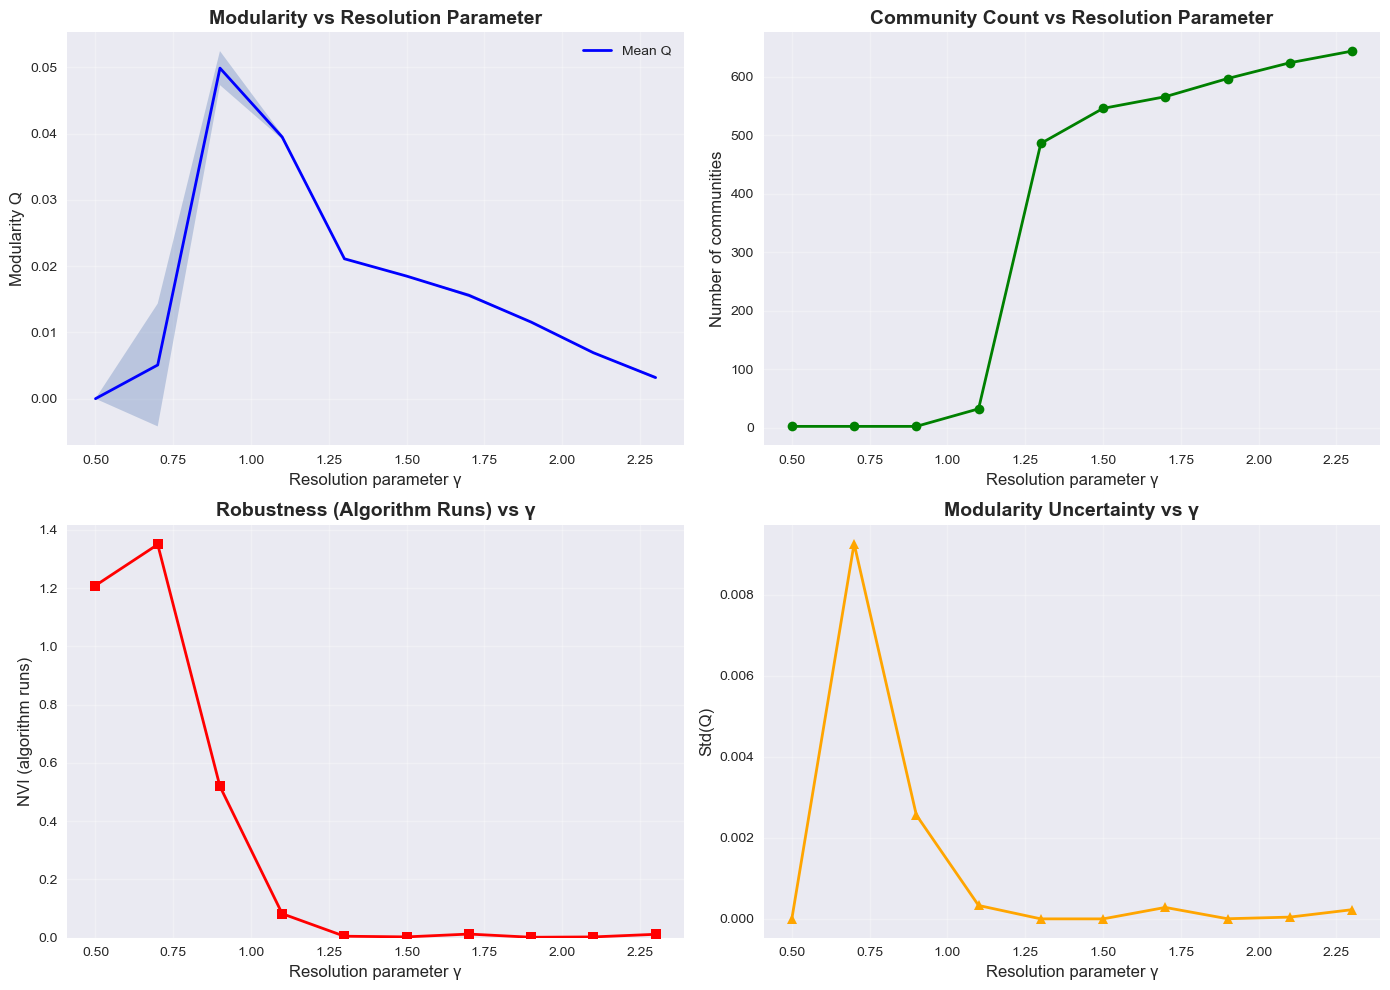


✅ Robust regions (NVI < 0.1):
   gamma    Q_mean  NVI_algo  n_communities
3    1.1  0.039495  0.082162             32
4    1.3  0.021119  0.004858            486
5    1.5  0.018505  0.002597            546
6    1.7  0.015606  0.012309            566
7    1.9  0.011567  0.001327            597
8    2.1  0.006941  0.002482            624
9    2.3  0.003191  0.011490            644


In [26]:
# ============================================================================
# PLOT RESOLUTION PARAMETER RESULTS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Q vs gamma
ax = axes[0, 0]
ax.plot(df_gamma['gamma'], df_gamma['Q_mean'], 'b-', linewidth=2, label='Mean Q')
ax.fill_between(df_gamma['gamma'], 
                 df_gamma['Q_mean'] - df_gamma['Q_std'],
                 df_gamma['Q_mean'] + df_gamma['Q_std'],
                 alpha=0.3)
ax.set_xlabel('Resolution parameter γ', fontsize=12)
ax.set_ylabel('Modularity Q', fontsize=12)
ax.set_title('Modularity vs Resolution Parameter', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

# Number of communities vs gamma
ax = axes[0, 1]
ax.plot(df_gamma['gamma'], df_gamma['n_communities'], 'g-', linewidth=2, marker='o')
ax.set_xlabel('Resolution parameter γ', fontsize=12)
ax.set_ylabel('Number of communities', fontsize=12)
ax.set_title('Community Count vs Resolution Parameter', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Robustness (NVI) vs gamma
ax = axes[1, 0]
ax.plot(df_gamma['gamma'], df_gamma['NVI_algo'], 'r-', linewidth=2, marker='s')
ax.set_xlabel('Resolution parameter γ', fontsize=12)
ax.set_ylabel('NVI (algorithm runs)', fontsize=12)
ax.set_title('Robustness (Algorithm Runs) vs γ', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_ylim(bottom=0)

# Q std vs gamma (uncertainty)
ax = axes[1, 1]
ax.plot(df_gamma['gamma'], df_gamma['Q_std'], 'orange', linewidth=2, marker='^')
ax.set_xlabel('Resolution parameter γ', fontsize=12)
ax.set_ylabel('Std(Q)', fontsize=12)
ax.set_title('Modularity Uncertainty vs γ', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find robust regions (low NVI = high robustness)
robust_regions = df_gamma[df_gamma['NVI_algo'] < 0.1]  # Arbitrary threshold
if len(robust_regions) > 0:
    print("\n✅ Robust regions (NVI < 0.1):")
    print(robust_regions[['gamma', 'Q_mean', 'NVI_algo', 'n_communities']])
else:
    print("\n⚠️ No regions with NVI < 0.1 found. Try adjusting threshold.")


In [27]:
# ============================================================================
# ROBUSTNESS ANALYSIS
# Three methods: random perturbation, algorithm runs, resolution parameter
# ============================================================================

# Choose a gamma value for detailed robustness analysis
# Use gamma=1.0 or pick from robust regions above
gamma_test = 1.0
print(f"Testing robustness at γ = {gamma_test:.2f}\n")

# Method 1: Random perturbation robustness
print("Method 1: Random perturbation robustness...")
M = 10  # Number of perturbed networks (increase for better estimate)
sigma = 0.1  # Perturbation strength
nvi_random = robustness_random_perturbation(G, gamma=gamma_test, M=M, sigma=sigma)
print(f"  <NVI>_random = {nvi_random:.4f}")

# Method 2: Algorithm run robustness
print("\nMethod 2: Algorithm run robustness...")
R_test = 20  # Number of runs (reduce for faster testing)
partitions_test, Q_test = louvain_multiple_runs(G, R=R_test, gamma=gamma_test, random_state=42)
nvi_algo = robustness_algorithm_runs(partitions_test)
print(f"  <NVI>_algo = {nvi_algo:.4f}")
print(f"  Q range: [{np.min(Q_test):.4f}, {np.max(Q_test):.4f}]")

# Method 3: Resolution parameter robustness
print("\nMethod 3: Resolution parameter robustness...")
delta_gamma = 0.01
Delta = 10
R_consensus = 10  # Runs per gamma for consensus
nvi_gamma = robustness_resolution_parameter(
    G, gamma=gamma_test, delta_gamma=delta_gamma, Delta=Delta, R=R_consensus
)
print(f"  <NVI>_γ = {nvi_gamma:.4f}")


Testing robustness at γ = 1.00

Method 1: Random perturbation robustness...
  <NVI>_random = 0.1825

Method 2: Algorithm run robustness...
  <NVI>_algo = 0.2091
  Q range: [0.0526, 0.0571]

Method 3: Resolution parameter robustness...


KeyboardInterrupt: 

In [ ]:
# Summary
print("\n" + "="*60)
print("ROBUSTNESS SUMMARY")
print("="*60)
print(f"Random perturbation (<NVI>_random):  {nvi_random:.4f}")
print(f"Algorithm runs (<NVI>_algo):        {nvi_algo:.4f}")
# print(f"Resolution parameter (<NVI>_γ):     {nvi_gamma:.4f}")
print("\nLower NVI values indicate higher robustness.")
print("="*60)

# Store consensus partition
consensus_test = consensus_partition(partitions_test, method='zrand')
print(f"\n✅ Consensus partition found with {len(set(consensus_test.values()))} communities")


ROBUSTNESS SUMMARY
Random perturbation (<NVI>_random):  0.1825
Algorithm runs (<NVI>_algo):        0.2091

Lower NVI values indicate higher robustness.

✅ Consensus partition found with 2 communities


Visualizing consensus partition...
Filtered graph: 734 nodes, 82836 edges
(min_weight threshold: 0.85)


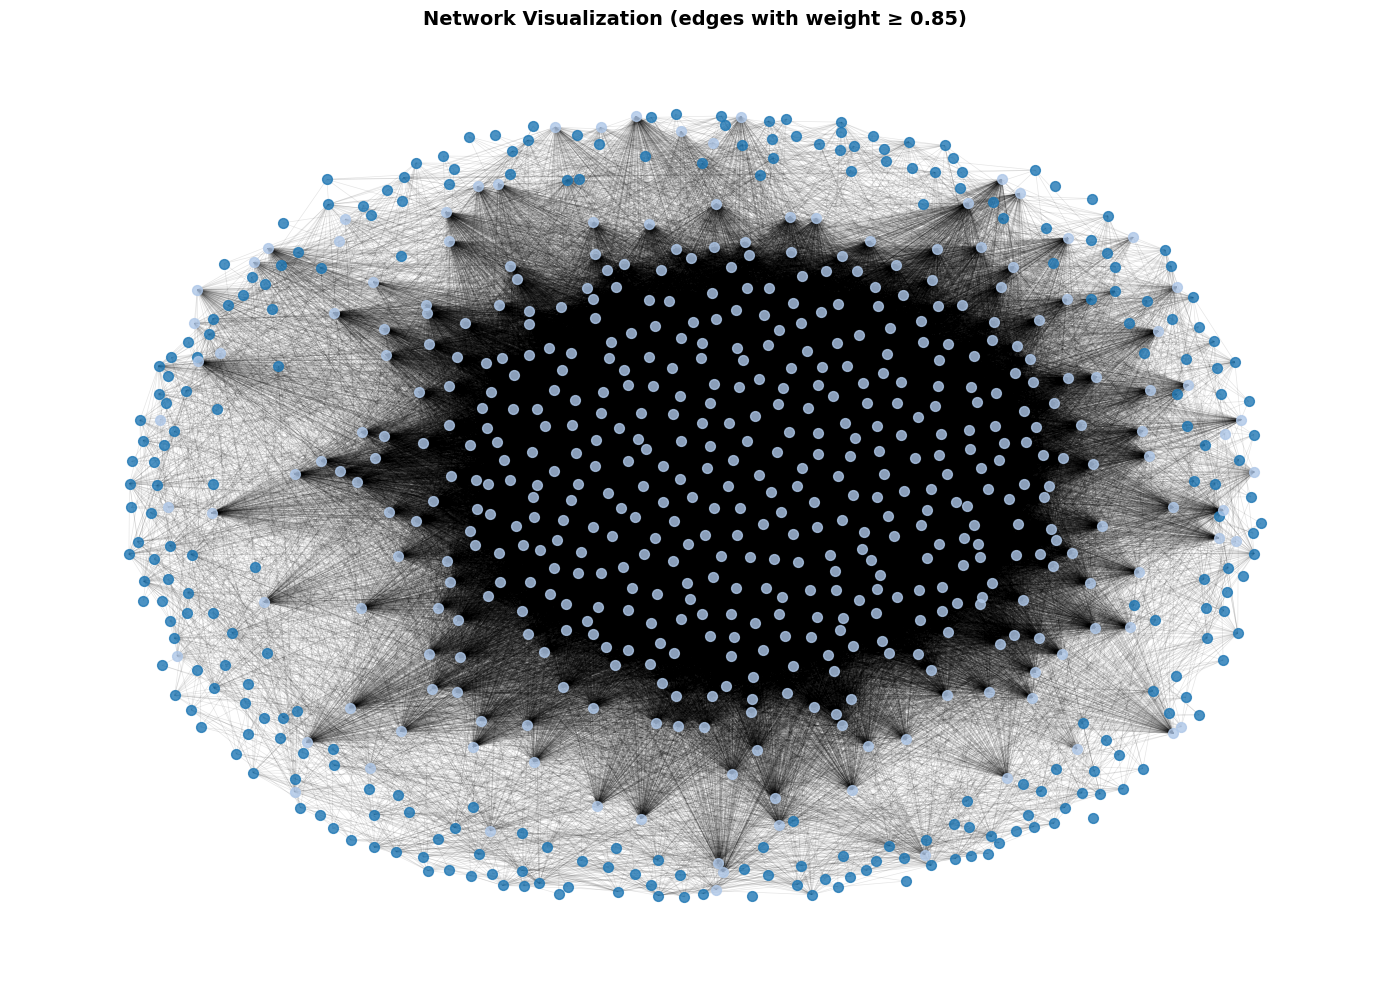

In [ ]:
# ============================================================================
# VISUALIZATION
# Network layout with community-aware positioning
# ============================================================================

def plot_network_with_communities(G, partition, min_weight=0.85, figsize=(14, 10)):
    """
    Visualize network with communities using Fruchterman-Reingold and Kamada-Kawai.
    Only shows edges with weight >= min_weight.
    """
    # Filter edges by weight
    G_filtered = G.copy()
    edges_to_remove = [(u, v) for u, v, d in G_filtered.edges(data=True) 
                       if d.get('weight', 0) < min_weight]
    G_filtered.remove_edges_from(edges_to_remove)
    
    print(f"Filtered graph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
    print(f"(min_weight threshold: {min_weight})")
    
    # Get community assignments
    communities = {}
    for node in G_filtered.nodes():
        communities[node] = partition.get(node, -1)
    
    # Create layout using Fruchterman-Reingold (community-aware)
    # Note: NetworkX doesn't have exact FRKK implementation, but we can use:
    # 1. FR for initial global layout
    # 2. Then adjust within communities
    
    # Use Fruchterman-Reingold for initial layout
    pos = nx.spring_layout(G_filtered, k=2, iterations=50, seed=1993)
    
    # Color nodes by community
    n_communities = len(set(communities.values()))
    colors = plt.cm.tab20(np.linspace(0, 1, max(n_communities, 20)))
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Draw edges
    nx.draw_networkx_edges(G_filtered, pos, alpha=0.1, width=0.5, ax=ax)
    
    # Draw nodes colored by community
    for comm_id in set(communities.values()):
        nodes_in_comm = [n for n in G_filtered.nodes() if communities[n] == comm_id]
        if nodes_in_comm:
            color_idx = comm_id % len(colors)
            nx.draw_networkx_nodes(
                G_filtered, pos, 
                nodelist=nodes_in_comm,
                node_color=[colors[color_idx]],
                node_size=50,
                alpha=0.8,
                ax=ax
            )
    
    ax.set_title(f"Network Visualization (edges with weight ≥ {min_weight})", 
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return pos


# Visualize consensus partition
if 'consensus_test' in locals():
    print("Visualizing consensus partition...")
    plot_network_with_communities(G, consensus_test, min_weight=0.85)
else:
    print("⚠️ Run robustness analysis first to generate consensus partition")
